In [86]:
import os
import pandas as pd
import numpy as np
import proplot as pplt
import xarray as xr

deformation_data_source = '../data/UsingAngelav2DanielCleanedInterpolatedTracks/'

files = os.listdir(deformation_data_source)
files = [f for f in files if f[0] != 'k']
key=pd.read_csv('../data/strainrate_computation_jan20_2021_jenny/key_to_triad_codes.csv')

def pad_node(node):
    if node[0] == 'P':
        return 'P' + '0' + node[1:]
    else:
        return node
key['node1'] = [pad_node(p) for p in key.node1]
key['node2'] = [pad_node(p) for p in key.node2]
key['node3'] = [pad_node(p) for p in key.node3]
key.set_index('label', inplace=True)


files = [f for f in os.listdir('../data/mosaic_interpolated_v1/') if f != '.DS_Store']
buoy_data = {f.split('_')[-1].replace('.csv', ''): pd.read_csv('../data/mosaic_interpolated_v1/' + f,
            index_col=0, parse_dates=True) for f in files}

metadataloc = '../../../packages/buoy_processing/data/adc_dn_tracks/'
metadata = pd.read_csv(metadataloc + 'DN_buoy_list_v2.csv')
metadata['filename'] = ['_'.join([x, str(y), z]) for 
                        x, y, z in zip(metadata['DN Station ID'],
                                       metadata['IMEI'],
                                       metadata['Sensor ID'])]
metadata.set_index('Sensor ID', inplace=True)
station_id = metadata.loc[:, 'DN Station ID']

def local_aeqd(lons, lats, lon0, lat0):
    """Local azimuthal equidistant projection centered at
    lat0, lon0. Intended use is just for i-1 and i+1, so should
    be within a kilometer or two and thus error from ellipse
    should be negligible."""
    
    import pyproj
    from pyproj import CRS
    crs0 = CRS('WGS84')
    crs1 = CRS("+proj=aeqd +lat_0={0} +lon_0={1} +ellps=WGS84 +units=m".format(lat0, lon0))
    transformer = pyproj.Transformer.from_crs(crs0, crs_to=crs1, always_xy=True)
    X, Y = transformer.transform(lons, lats)
    return X, Y


center_buoy = 'ASFSTUCB1'
lon0 = buoy_data[center_buoy]['longitude'].median()
lat0 = buoy_data[center_buoy]['latitude'].median()
for buoy in buoy_data:
    lon = buoy_data[buoy]['longitude']
    lat = buoy_data[buoy]['latitude']
    x, y = local_aeqd(lon, lat, lon0, lat0)
    buoy_data[buoy]['x'] = x
    buoy_data[buoy]['y'] = y
timeslice = slice('2020-01-29', '2020-02-04')
buoy_data = {buoy: buoy_data[buoy] for buoy in buoy_data if len(buoy_data[buoy].loc[timeslice]) > 0}    
ds_adj = xr.concat([buoy_data[buoy].loc[:, ['latitude', 'longitude', 'x', 'y', 'u', 'v']].to_xarray() for buoy in buoy_data],
                   dim=pd.Index([buoy for buoy in buoy_data], name='site'))



In [87]:
truncated_list = []
stations_already = []
full_time_series = [b for b in buoy_data if len(buoy_data[b]) >= 150]
for buoy in full_time_series:
    if station_id[buoy] not in stations_already:
        stations_already.append(station_id[buoy])
        truncated_list.append(buoy)
lat = pd.Series({buoy: buoy_data[buoy]['latitude'].median() for buoy in truncated_list})
lon = pd.Series({buoy: buoy_data[buoy]['longitude'].median() for buoy in truncated_list})
distant_buoys = lat[(lat < 87) | (lon < 80)].index.tolist()
near_buoys = [b for b in truncated_list if b not in distant_buoys]

In [88]:
for i in range(len(key)):
    for j in range(len(key.T)):
        site = key.iloc[i, j]
        buoys = station_id[station_id == site].index
        if len(buoys) > 0:
            key.iloc[i, j] = np.unique(buoys)[0]

In [89]:
for name, group in metadata.loc[[b for b in buoy_data]].groupby('DN Station ID'):
    print(name, group.index.values)
    if name[0] == 'P':
        break

CO1 ['2019F4' 'ASFSTUCB1']
L1 ['2019R8' '2019T67' 'ASFS40UCB1']
L2 ['2019R9' '2019W2' '2019T63' '2019S93' '2019F2' 'ASFS30UCB1' '2019T65']
L3 ['2019S94' '2019T70' '2019F3' '2019M30' '2019W3' 'ASFS50UCB1']
LM ['2019T66' '2019S96' '2019T62']
M1 ['2019T68' '2019V1' '2019O1']
M2 ['2019V2']
M3 ['2019O3' '2019T59' '2019V3' '2019S81']
M4 ['2019O4' '2019T58']
M5 ['2019S87' '2019V4' '2019T72' '2019O5']
M6 ['2019O6' '2019S86' '2019T64']
M8 ['2019T69']
P001 ['2019P207']


In [90]:
X_data = pd.DataFrame({b: buoy_data[b]['x'] for b in buoy_data})
Y_data = pd.DataFrame({b: buoy_data[b]['y'] for b in buoy_data})
date = pd.to_datetime('2020-02-01 00:00')
dist = pd.DataFrame(np.zeros((len(X_data.columns), len(X_data.columns))),
                    index=X_data.columns, columns=X_data.columns)
for b1 in buoy_data:
    for b2 in buoy_data:
        dist.loc[b1, b2] = np.sqrt(
            (X_data.loc[date, b1] - X_data.loc[date, b2])**2 + \
        (Y_data.loc[date, b1] - Y_data.loc[date, b2])**2)

In [91]:
dist.loc[['2019R9','2019T63','2019S93','ASFS30UCB1','2019T65'],
         ['2019R9','2019T63','2019S93','ASFS30UCB1','2019T65']]

,2019R9,2019T63,2019S93,ASFS30UCB1,2019T65
2019R9,0.000000,238.162023,31.343837,61.882786,260.040049
2019T63,238.162023,0.000000,225.884866,282.396326,22.460136
2019S93,31.343837,225.884866,0.000000,57.528616,247.010055
ASFS30UCB1,61.882786,282.396326,57.528616,0.000000,303.163203
2019T65,260.040049,22.460136,247.010055,303.163203,0.000000


In [92]:
# Order = L1, L2, L3
polygons = {
    'Lsites_1': ['2019R8', '2019R9', '2019S94'],
    'Lsites_2': ['2019T67', '2019T63', '2019S94'],
    'Lsites_3': ['ASFS40UCB1', 'ASFS30UCB1', '2019M30'],
    'Lsites_4': ['2019P209', '2019P199', '2019P200'],
    'Lsites_5': ['2019P202', '2019P188', '2019P206']
}

In [93]:
key['num_avail'] = 0
for idx, row in key.iterrows():
    present = np.sum([x in full_time_series for x in row])
    key.loc[idx, 'num_avail']=present


In [94]:
draw_nodes = key.loc[key.num_avail == 3].index.to_list()

In [99]:
ds_adj['x'].sel(datetime='2020-01-29')

<xarray.DataArray 'x' (site: 101, datetime: 24)>
array([[  9920.43222326,   9755.95251911,   9611.14648062, ...,
         10624.38227978,  10994.26890754,  11352.50894874],
       [-20386.5180502 , -20547.07010501, -20696.09936997, ...,
        -19485.83277982, -19106.94760478, -18737.05397658],
       [  1563.3986777 ,   1396.93527469,   1249.44264345, ...,
          2254.00923526,   2616.17269062,   2970.49556449],
       ...,
       [  1676.61196822,   1511.14333081,   1361.68335219, ...,
          2381.54709561,   2746.00876798,   3100.3318546 ],
       [-22076.30564284, -22258.02189325, -22429.17333507, ...,
        -21363.20134767, -21015.85420151, -20682.74680018],
       [  3374.56700983,   3207.23554253,   3060.22368769, ...,
          4015.2121936 ,   4372.60300186,   4720.81297512]])
Coordinates:
  * datetime  (datetime) datetime64[ns] 2020-01-29 ... 2020-01-29T23:00:00
  * site      (site) object '2019R9' '2019P142' ... '2019T64' '2019P103'

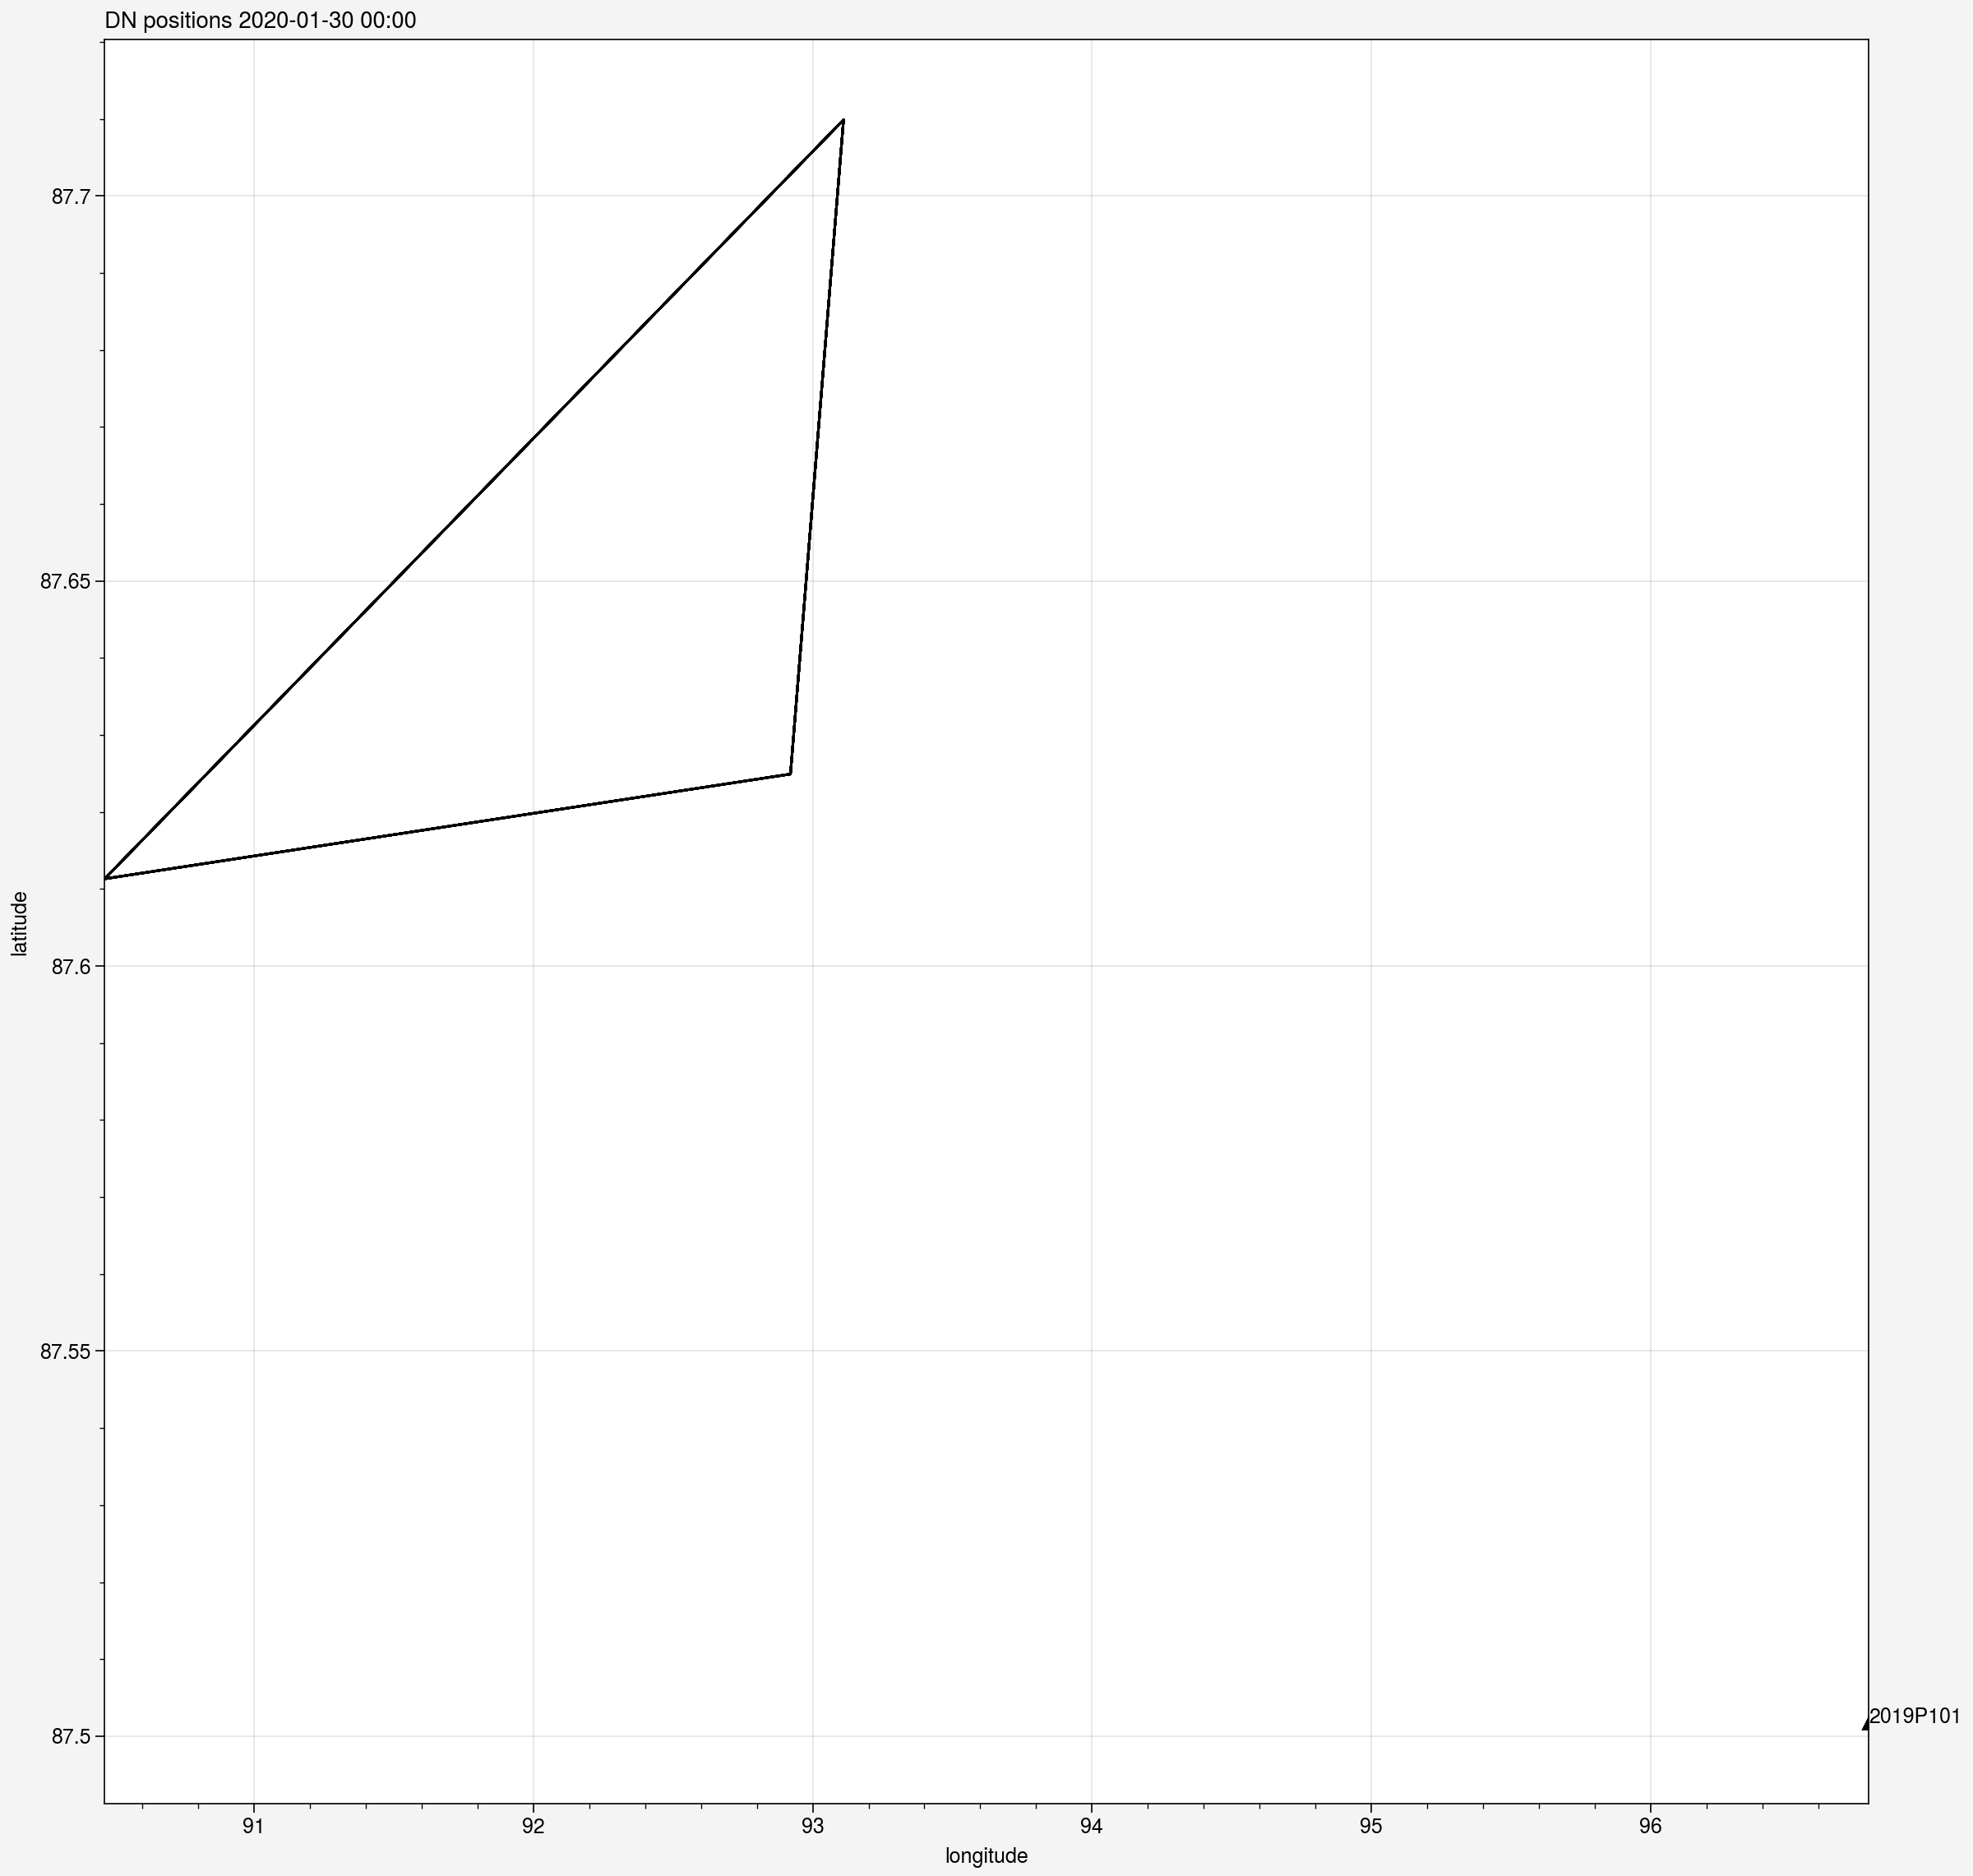

In [96]:
date = '2020-01-30 00:00'
idx = slice('2020-02-01 00:00', '2020-02-05')
colors = {'L': 'b', 'M': 'g', 'C': 'r', 'P': 'k'}
markers = {'L': 's', 'M': 'o', 'C': '*', 'P': '^'}
fig, ax = pplt.subplots(width=12)
for site in near_buoys:
    station = station_id[site]
    zorder = 0
    m = markers[station[0]]
    s = 5
    if station[0] != 'P':
        zorder = 1
    if station[0] == 'C':
        zorder = 2
    if station[0:2] == 'LM':
        m = '*'
        c = 'darkred'
        s = 15
    else:
        c = colors[station[0]]
    
    ax.plot(ds_adj.sel(site=site, datetime=date).longitude, 
            ds_adj.sel(site=site, datetime=date).latitude, 
            marker=m,
            markersize=s,
            color=c, zorder=zorder)
    ax.text(ds_adj.sel(site=site, datetime=date).longitude, 
            ds_adj.sel(site=site, datetime=date).latitude, 
                site)
               #str(np.round(hourly_dfs[buoy].loc[idx, 'time_till_next'].max(),2)))

    ax.format(ltitle='DN positions ' + date)
    
for node in draw_nodes:

    #buoys = polygons[node]
    buoys = ['2019O6', '2019P196', '2019P198']
    draw_polygon = buoys + [buoys[0]]
    #key.loc[node, ['node1', 'node2', 'node3', 'node1']].values
    ax.plot(ds_adj.sel(site=draw_polygon, datetime=date).longitude, 
            ds_adj.sel(site=draw_polygon, datetime=date).latitude, 
            lw=1,
            color='k', zorder=3, alpha=0.3)
ax.format(xreverse=False, yreverse=False)
#fig.save('../figures/polygons.jpg', dpi=300)

In [275]:
# Getting distinct polygons
# Other options for s42 to replace 2019O3: '2019S81', '2019T59', '2019V3'
# Other options for s42 to replace 2019O4: '2019S80', '2019T58'
#metadata.loc[metadata['DN Station ID'] == 'M4']

In [47]:

def convert_factor(x):
    try:
        return float(x)
    except:
        return np.nan
    
deformation_data = {}
prefix = 'strainrate_MOSAiC_DN_fulldrift_'


files = os.listdir(deformation_data_source)
for file in files:
    node = file.split('_')[-1]
    if node.split('.')[-1] != 'csv':
        pass
    else:
        node = node.replace('.csv', '')
        data = pd.read_csv(deformation_data_source + prefix + node + '.csv')
        data.columns = [x.strip() for x in data.columns]
        data['datetime'] = pd.to_datetime('2019-10-04 00:00') + pd.to_timedelta(data.day.values, unit='D')
        data['shape factor'] = [convert_factor(x) for x in data['shape factor']]
        data.set_index('datetime', inplace=True)
        deformation_data[node] = data #.loc[slice('2020-01-25', '2020-02-05')].copy()




Estimating the strain-rate components (following Hutchings 2012, 2018)

In [48]:
def strain_rate(buoys, data):
    """Compute the four components of strain rate for each
    date in data. 
    Columns: 'divergence', 'vorticity',
             'pure_shear', 'normal_shear',
             'maximum_shear_strain_rate', 'area', 'shape_flag'

    Additional columns for the uncertainty will be added.
    """
    def check_order(buoys, date, data):
        """Pass through. Right hand rule enforcement tbd"""
        return buoys

    def check_shape(buoys, date, data):
        """Pass through. Return True if the shape is too skewed."""
        return False

    def polygon_area(X, Y):

        s2 = 0.
        N = len(X)
        s1 = X[N-1]*Y[0] - X[0]*Y[N-1]
        for i in range(N - 1):
            s2 += X[i]*Y[i+1] - Y[i]*X[i+1]
        return (s2 + s1)*0.5

    def accel(X, U, A, sign):
        """Computes spatial derivative of velocity for 
        deformation."""
        N = len(X)
        sumvar = 0
        s1 = (U[0] + U[N-1])*(X[0] - X[N-1])
        for i in range(N - 1):
            sumvar += (U[i+1] + U[i])*(X[i+1] - X[i])
        return 1/(2*A) * (sumvar + s1) * sign

    X_data = pd.DataFrame({b: data[b]['x'] for b in buoys})
    Y_data = pd.DataFrame({b: data[b]['y'] for b in buoys})
    U_data = pd.DataFrame({b: data[b]['u'] for b in buoys})
    V_data = pd.DataFrame({b: data[b]['v'] for b in buoys})

    results = []
    for date in X_data.index:
        buoys = check_order(buoys, date, data)
        flag = check_shape(buoys, date, data)
        
        X = X_data.loc[date, :]
        Y = Y_data.loc[date, :]
        U = U_data.loc[date, :]
        V = V_data.loc[date, :]
        
        A = polygon_area(X, Y)
            
        dudx = accel(Y, U, A, 1)
        dudy = accel(X, U, A, -1)
        dvdx = accel(Y, V, A, 1)
        dvdy = accel(X, V, A, -1)
        
        results.append([
            dudx + dvdy, #div
            dvdx - dudy, #vor
            dudy + dvdx, #pure
            dudx - dvdy, #normal
            0.5*np.sqrt((dudx - dvdy)**2 + (dudy + dvdx)**2),
            A,
            flag
        ])
        
        
    return pd.DataFrame(
        np.vstack(results),
        columns=['divergence', 'vorticity', 'pure_shear',
                 'normal_shear', 'maximum_shear_strain_rate',
                 'area', 'shape_flag'],
        index=X_data.index)

In [49]:
# area with shapely
from shapely.geometry import Polygon
area_shapely = []
area_summing = []
for date in buoy_data[buoys[0]].index:
#    area_summing.append(polygon_area(X_data.loc[date], Y_data.loc[date]))
    area_shapely.append(Polygon([(x, y) for x, y in zip(X_data.loc[date], Y_data.loc[date])]).area)
area_shapely = pd.Series(area_shapely, index=X_data.index)
#area_summing = pd.Series(area_summing, index=X_data.index)

 do not form a closed linestring


ValueError: GEOSGeom_createLinearRing_r returned a NULL pointer

In [50]:
key2 = {'blue': ['2019P205', '2019P146',  '2019P204'],
       'green': ['2019P136', '2019T69', '2019T58', '2019T63' ],
       'orange': ['2019P143', '2019P90', '2019T59', '2019P190', '2019P92', '2019S81']}

In [51]:
for buoy in key2['orange']:
    print(buoy, buoy in buoy_data, )

2019P143 True
2019P90 True
2019T59 True
2019P190 True
2019P92 True
2019S81 True


In [52]:
node = 's06'
buoys = {'s06': ['2019S96', '2019P197', '2019P205'],
        's22': ['2019O6', '2019P196', '2019P198'],
        's42': ['2019O4', '2019P103', '2019O3'],
        's57': [ '2019O1', '2019P191', '2019P92']}[node]

node = 'orange'
buoys = key2[node]
jenny_df = deformation_data[node]

test = strain_rate(buoys, buoy_data)
#alternate = strain_rate(['2019O4', '2019P103', '2019S81'], buoy_data)
#metadata.loc[buoys]

In [ ]:
%%time
# area with shapely
from shapely.geometry import Polygon
area_shapely = []
for date in buoy_data[buoys[0]].index:
    X = np.array([buoy_data[b].loc[date, 'x'] for b in buoys])
    Y = np.array([buoy_data[b].loc[date, 'y'] for b in buoys])
    area_shapely.append(Polygon([(x, y) for x, y in zip(X, Y)]).area)
area_shapely = pd.Series(area_shapely, index=buoy_data[buoys[0]].index)

There are some notable differences between the area computed by Jenny from the ADC tracks and the area I get. Some differences may be from differences in projection.

In [58]:
jenny_df = jenny_df.where(jenny_df.flag == 0)

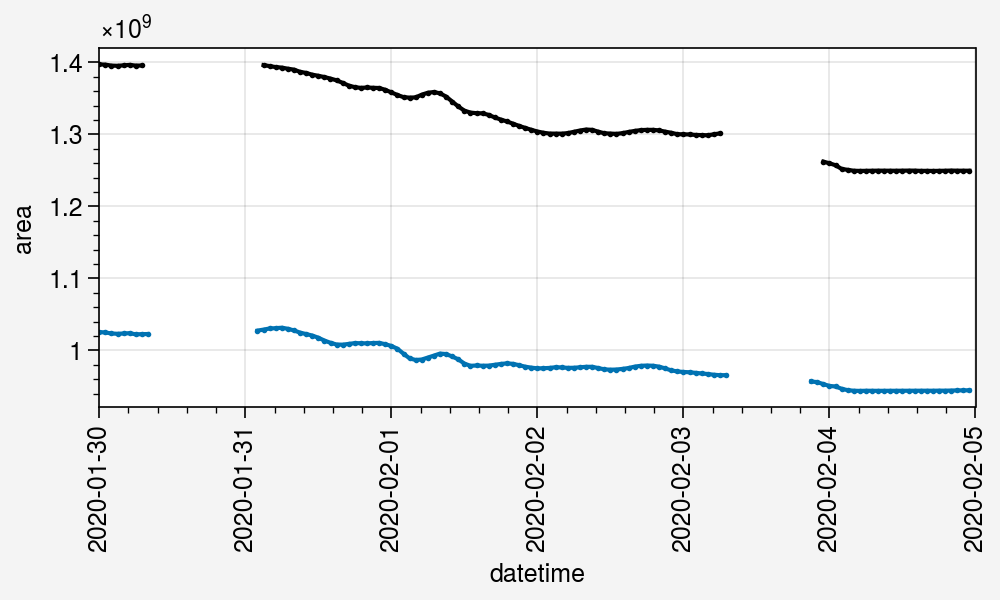

In [59]:
timeslice = slice('2020-01-30', '2020-02-04')
fig, ax = pplt.subplots(width=5, height=3)
ax.plot(np.abs(test.area.loc[timeslice]), marker='.', markersize=2)
#ax.plot(area_shapely.loc[timeslice], color='r')
ax.plot(jenny_df.area.loc[timeslice], marker='.',
         color='k', markersize=2)
fig.format(xlim=(pd.to_datetime('2020-01-30'), pd.to_datetime('2020-02-05')))

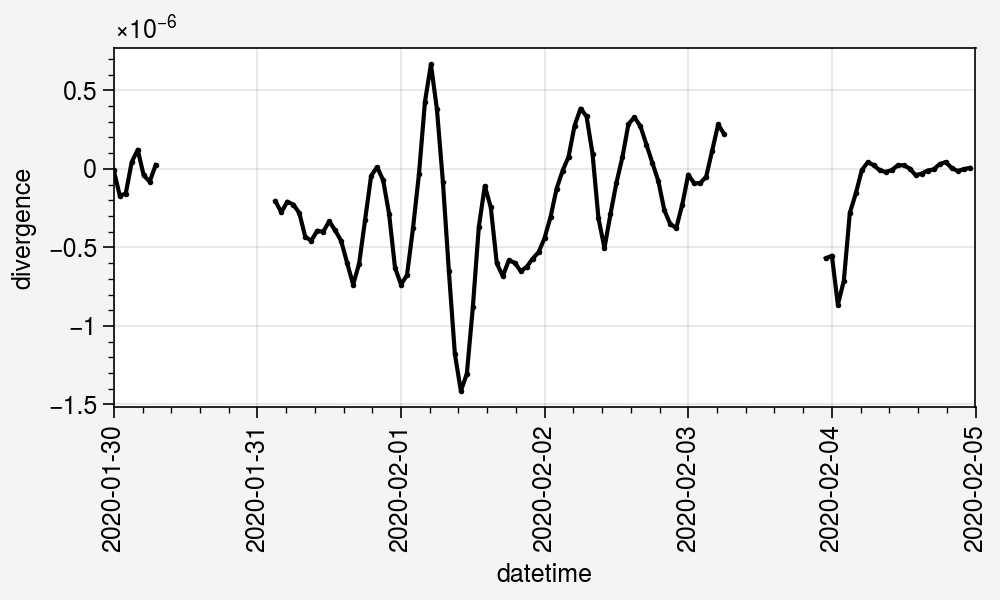

In [100]:
timeslice = slice('2020-01-30', '2020-02-04')
fig, ax = pplt.subplots(width=5, height=3)
#ax.plot(test.pure_shear.loc[timeslice], marker='.', markersize=2)
#ax.plot(area_shapely.loc[timeslice], color='r')
ax.plot(jenny_df['divergence'].loc[timeslice], marker='.',
         color='k', markersize=2)
fig.format(xlim=(pd.to_datetime('2020-01-30'), pd.to_datetime('2020-02-05')))

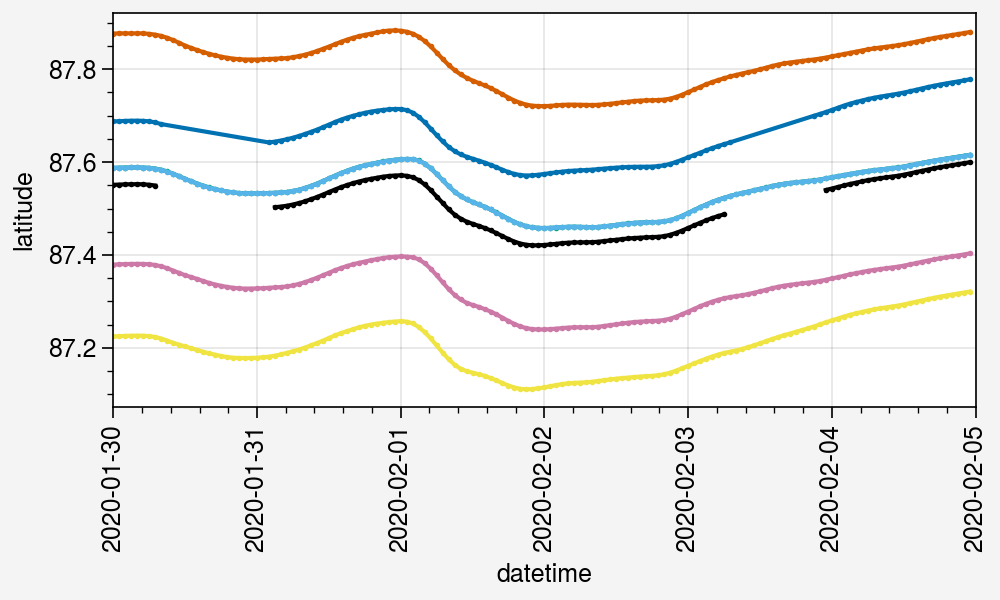

In [60]:
timeslice = slice('2020-01-30', '2020-02-04')
fig, ax = pplt.subplots(width=5, height=3)
for buoy in buoys:
    ax.plot(buoy_data[buoy].loc[timeslice].latitude, marker='.', markersize=2)
ax.plot(jenny_df['mean latitude'].loc[timeslice], marker='.',
         color='k', markersize=2)
fig.format(xlim=(pd.to_datetime('2020-01-30'), pd.to_datetime('2020-02-05')))



In [450]:
# Buoy data from the ADC
# Check: did I replace this with QC data?
buoys_initial = {}
for file in [metadata.loc[b, 'filename'] for b in buoys]:
    buoys_initial[file.split('_')[-1].replace('.csv', '')] = pd.read_csv('../data/adc_dn_tracks/' + file + '.csv',
                                   index_col=2, parse_dates=True
                                )

In [451]:
# timeslice = slice('2020-01-30 12:00', '2020-02-01')
# fig, ax = pplt.subplots(nrows=3, width=6, height=5, sharey=False)
# for b in buoys:
#     lat = buoys_initial[b]['latitude'].loc[timeslice]
#     ax[0].plot(lat, marker='.')
#     lat = buoy_data[b]['latitude'].loc[timeslice]
#     ax[0].plot(lat, marker='', color='k')

#     lon = buoys_initial[b]['longitude'].loc[timeslice]
#     ax[1].plot(lon, marker='.')
#     lon = buoy_data[b]['longitude'].loc[timeslice]
#     ax[1].plot(lon, marker='', color='k')

# ax[2].plot(test.area.loc[timeslice], marker='.', markersize=2)
# #ax[2].plot(jenny_df.area.loc[timeslice], marker='.',
# #         color='k', markersize=2)



In [452]:
# fig, ax = pplt.subplots(width=5, height=3)
# ax.plot((buoys_initial['2019O1'].latitude - buoys_initial['2019O1'].latitude.shift(1)).loc[timeslice], marker='.')

# #ax.plot(buoy_data['2019O1'].latitude - buoy_data['2019O1'].latitude.shift(1), marker='.')



# Questions
1. Do the discrepencies between Jenny's and my calculations of area coincide with bad data that I removed?
2. What percent difference is there in the areas? Is this difference to be expected due to differences in where the LAEA was centered?
3. How much do the strain rate calculations change?
4. Is the shapely method faster or slower? I lean toward using shapely where possible, especially to get triangulations and convex hulls. Are there tools for doing line integrals on Shapely polygons?

# Deformation in the region of the L array
I calculated deformation values using 5 similar triangle: 3 using different subsets of L sites, and 2 additional triangles that are similar size overlapping the same area.



In [453]:
data = {site: strain_rate(polygons[site], buoy_data) for site in polygons}

jenny_ldata = pd.read_csv('../data/strainrate_MOSAiC_DN_fulldrift_Ltriangle.csv')
jenny_ldata.columns = [x.strip() for x in jenny_ldata.columns]
jenny_ldata.index = pd.to_datetime(jenny_ldata['date time'].values)
jenny_ldata = jenny_ldata.loc[slice('2020-01-29', '2020-02-04')].copy()


In [454]:
jenny_ldata.rename({'maximum shear': 'maximum_shear_strain_rate',
                    'pure shear': 'pure_shear',
                    'normal shear': 'normal_shear'}, axis=1, inplace=True)

KeyError: 'area'

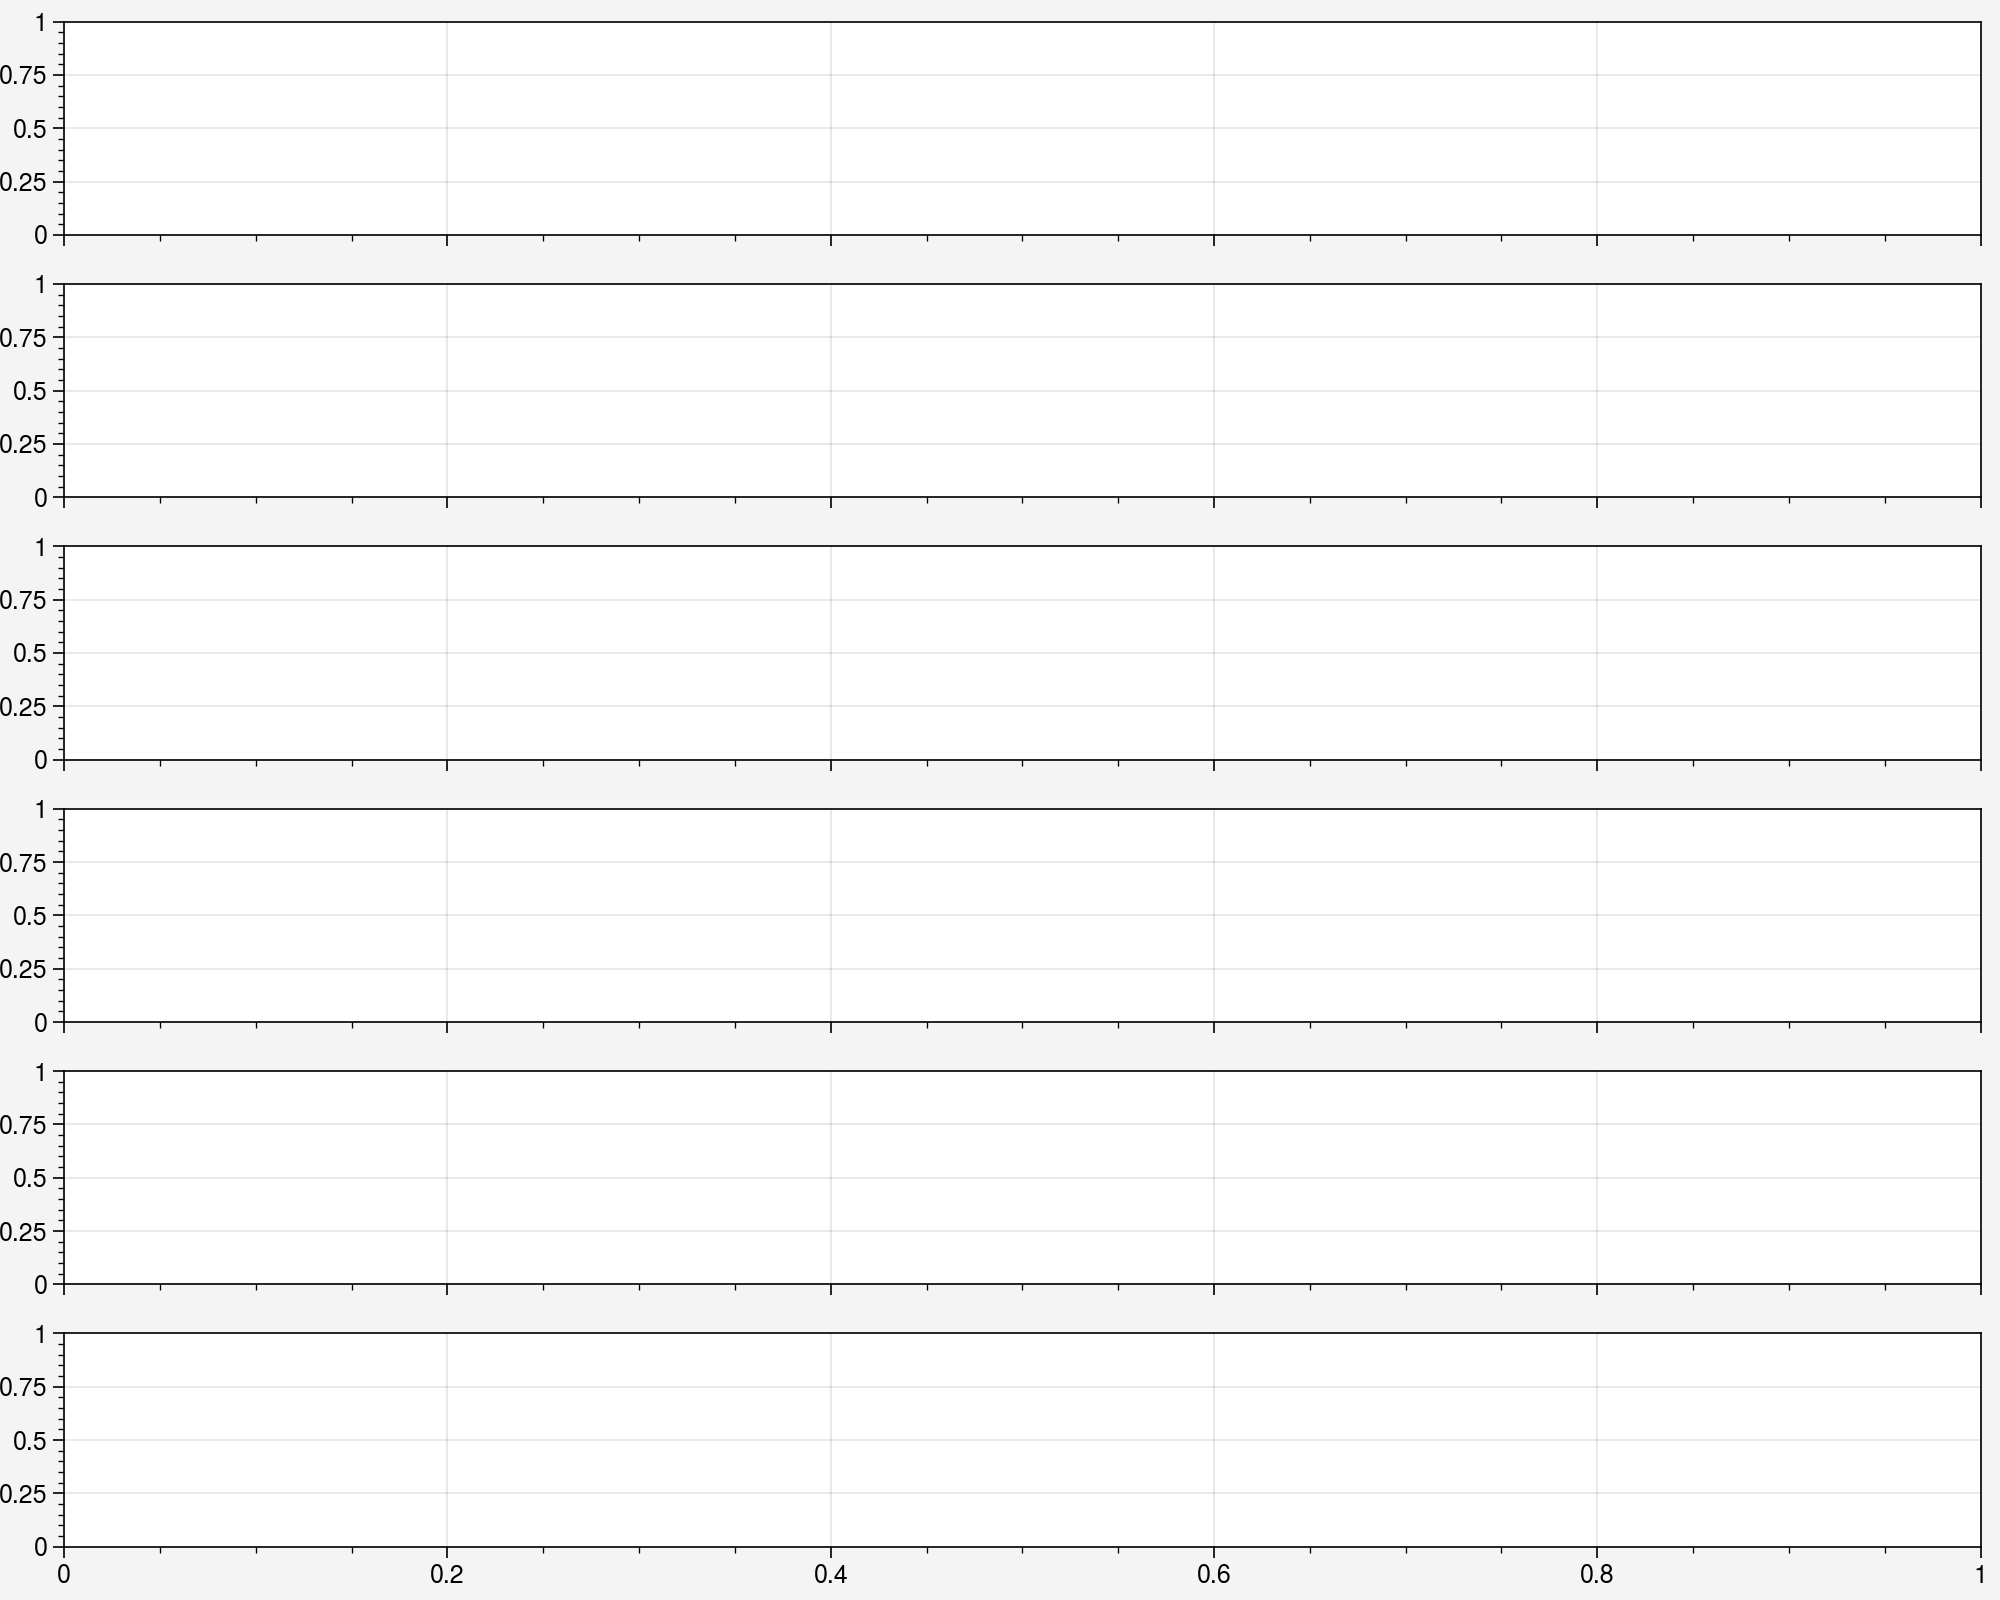

In [64]:
fig, axs = pplt.subplots(width=10, nrows=6, height=8, sharey=False)
for ax, variable in zip(axs, ['area', 'divergence', 'vorticity', 'pure_shear', 'normal_shear', 'maximum_shear_strain_rate']):
    for site in data:
        ax.plot(data[site][variable], label=site,
                )
        ax.format(title=variable.replace('_', ' ').title())
    if variable in ['vorticity', 'normal_shear']:
        ax.plot(-1*jenny_ldata[variable], label='-1 $\\times$ Jenny\'s Computation', ls='--')
        h = ax.plot([],[],ls='--', color='light blue')
        ax.legend(h, ['$\\times$ -1'], loc='ll')        
    else:
        ax.plot(jenny_ldata[variable], label='Jenny\'s Computation')
# axs[0].format(ylabel='Area ($m^2$)')
# axs[1].format(ylabel='Div ($s^-1$)')
# axs[2].format(ylabel='Vorticity')
# axs[2].format(ylabel='Pure Shear')
# axs[2].format(ylabel='Max Sh. Str. ($s^-1$)')
axs[1].legend(loc='r', ncols=1)
axs.format(xformatter='%b-%d', xlabel='', xrotation=45, xlim=(pd.to_datetime('2020-01-29 00:00'),
                                                              pd.to_datetime('2020-02-04 00:00')))
#fig.save('../figures/l_sites_deformation.jpg', dpi=300)

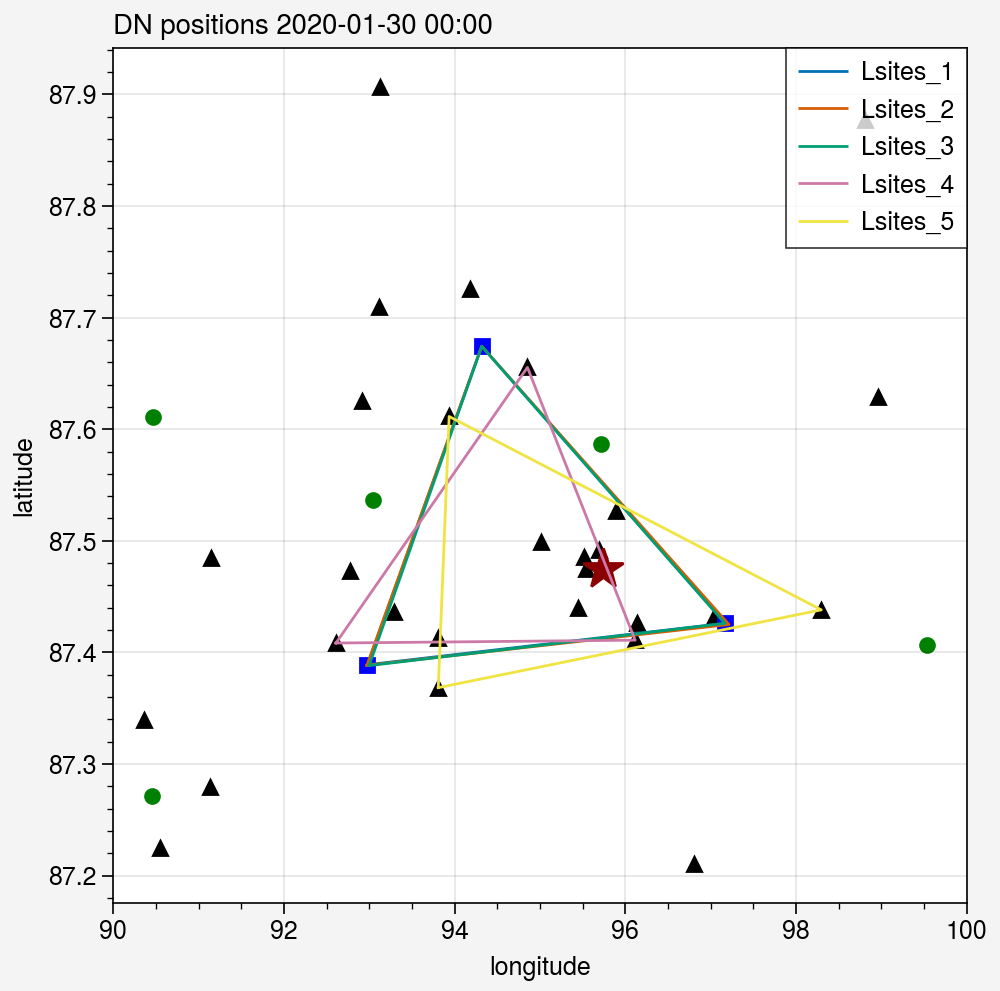

In [320]:
date = '2020-01-30 00:00'
timeslice = slice('2020-01-29 00:00', '2020-01-31')
colors = {'L': 'b', 'M': 'g', 'C': 'darkred', 'P': 'k'}
markers = {'L': 's', 'M': 'o', 'C': '*', 'P': '^'}
fig, ax = pplt.subplots(width=5)
for site in near_buoys:
    station = station_id[site]
    zorder = 0
    m = markers[station[0]]
    s = 5
    if station[0] != 'P':
        zorder = 1
    if station[0] == 'C':
        zorder = 2
        s = 15
    if station[0:2] == 'LM':
        m = markers['P'] #'*'
        c = colors['P'] #'darkred'
        s = 5 #15
    else:
        c = colors[station[0]]
    
    ax.plot(ds_adj.sel(site=site, datetime=date).longitude, 
            ds_adj.sel(site=site, datetime=date).latitude, 
            marker=m,
            markersize=s,
            color=c, zorder=zorder)
#     ax.text(ds_adj.sel(site=site, datetime=date).longitude, 
#             ds_adj.sel(site=site, datetime=date).latitude, 
#                 site)
               #str(np.round(hourly_dfs[buoy].loc[idx, 'time_till_next'].max(),2)))

    ax.format(ltitle='DN positions ' + date)
    
for node in polygons:
    try:
        buoys = polygons[node]
        draw_polygon = buoys + [buoys[0]]
        #key.loc[node, ['node1', 'node2', 'node3', 'node1']].values
        ax.plot(ds_adj.sel(site=draw_polygon, datetime=date).longitude, 
                ds_adj.sel(site=draw_polygon, datetime=date).latitude, 
                lw=1,
                zorder=3, alpha=1, label=node)
    except:
        print(node)
ax.legend(loc='ur', ncols=1)
ax.format(xreverse=False, yreverse=False, xlim=(90, 100))
fig.save('../figures/polygons.jpg', dpi=300)

In [466]:
d = dist.loc['ASFSTUCB1',:].sort_values()
d[d < 10e3]

ASFSTUCB1        0.000000
2019P158       955.617200
2019T66       1641.706911
2019P151      1689.199887
2019T62       1832.663541
2019S96       1833.011262
2019P183      1889.556931
2019P150      2283.135470
2019P204      4113.528416
2019P207      4510.141846
2019P103      5075.432737
2019P101      5684.047827
2019P201      5794.151918
2019P199      7353.469162
2019P146      8558.840832
2019P195      8844.194927
ASFS30UCB1    9717.826726
2019R9        9750.390942
2019S93       9768.539782
2019T63       9985.851415
Name: ASFSTUCB1, dtype: float64

In [342]:
near_center = ['ASFSTUCB1', '2019P158', '2019T66', '2019P151', '2019T62', '2019S96',
       '2019P183', '2019P150']
smooth_center_x = X_data.loc[:, near_center].mean(axis=1).rolling('3H', center=True).mean()
smooth_center_y = Y_data.loc[:, near_center].mean(axis=1).rolling('3H', center=True).mean()

In [343]:
for buoy in buoy_data:
    buoy_data[buoy]['x_anom'] = buoy_data[buoy]['x'] - smooth_center_x
    buoy_data[buoy]['y_anom'] = buoy_data[buoy]['y'] - smooth_center_y

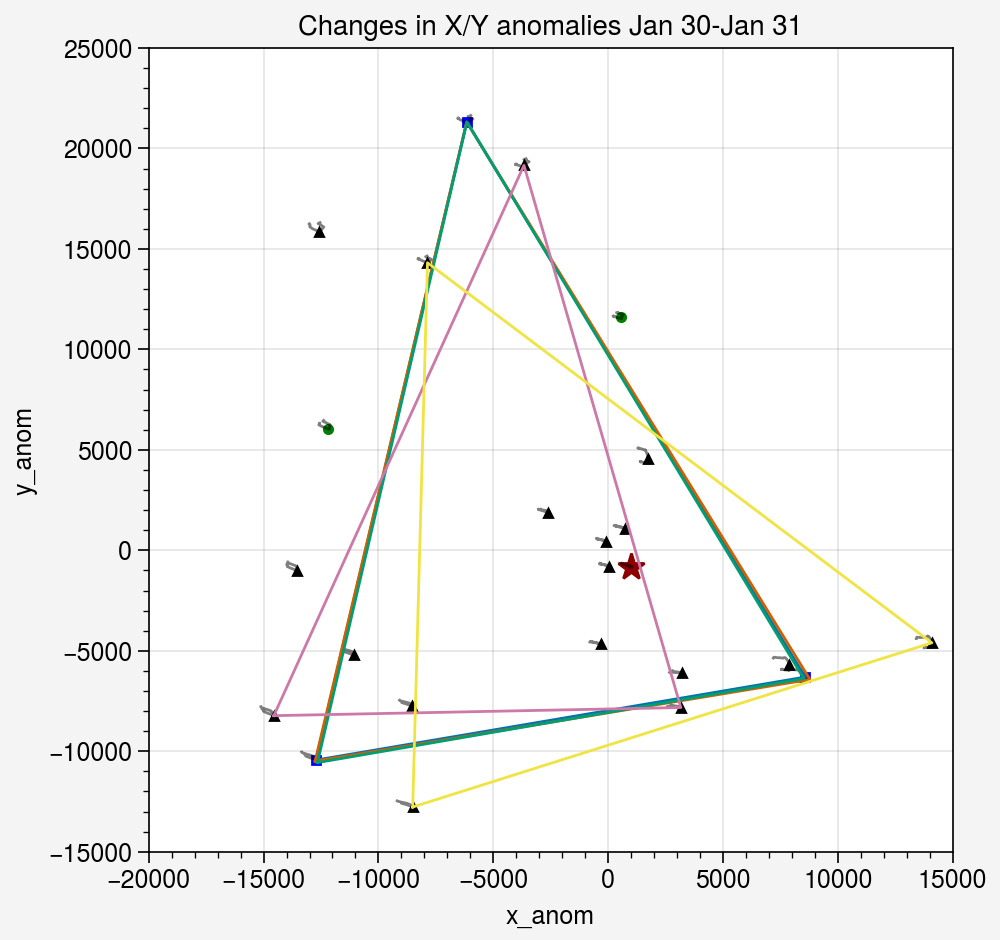

In [370]:
date = '2020-01-30 12:00'
timeslice = slice('2020-01-30 00:00', '2020-01-31 00:00')
title_dates = 'Jan 30-Jan 31'

# date = '2020-01-31 06:00'
# timeslice = slice('2020-01-31 00:00', '2020-01-31 12:00')
# title_dates = 'Jan 31 00-12Z'

# date = '2020-02-01 0:00'
# timeslice = slice('2020-01-31 12:00', '2020-02-01 12:00')
# title_dates = 'Jan 31 12Z-Feb 1 12Z'



fig, ax = pplt.subplots(width=5)
for buoy in near_buoys:
    
    station = station_id[buoy]
    zorder = 0
    m = markers[station[0]]
    s = 3
    if station[0] != 'P':
        zorder = 1
    if station[0] == 'C':
        zorder = 2
        s = 10
    if station[0:2] == 'LM':
        m = markers['P'] #'*'
        c = colors['P'] #'darkred'
        s = 3 #15
    else:
        c = colors[station[0]]
    
    ax.plot(buoy_data[buoy].loc[date, 'x_anom'], 
            buoy_data[buoy].loc[date, 'y_anom'], 
            marker=m,
            markersize=s,
            color=c, zorder=zorder)
    
    ax.plot(buoy_data[buoy]['x_anom'].loc[timeslice],
            buoy_data[buoy]['y_anom'].loc[timeslice],
            marker='', color='k', lw=1, alpha=0.5)
for node in polygons:

    buoys = polygons[node]
    draw_polygon = buoys + [buoys[0]]
    X = [buoy_data[buoy].loc[date, 'x_anom'] for buoy in draw_polygon]
    Y = [buoy_data[buoy].loc[date, 'y_anom'] for buoy in draw_polygon]
    ax.plot(X, Y,
            lw=1,
            zorder=3, alpha=1, label=node)

ax.format(ylim=(-15e3, 25e3), xlim=(-20e3, 15e3))    
ax.format(xreverse=False, yreverse=False, title='Changes in X/Y anomalies ' + title_dates)
fig.save('../figures/' + 'tracks_anomalies_' + title_dates.replace(' ', '') + '.jpg', dpi=300) 

Overlaying the paths of separate corners

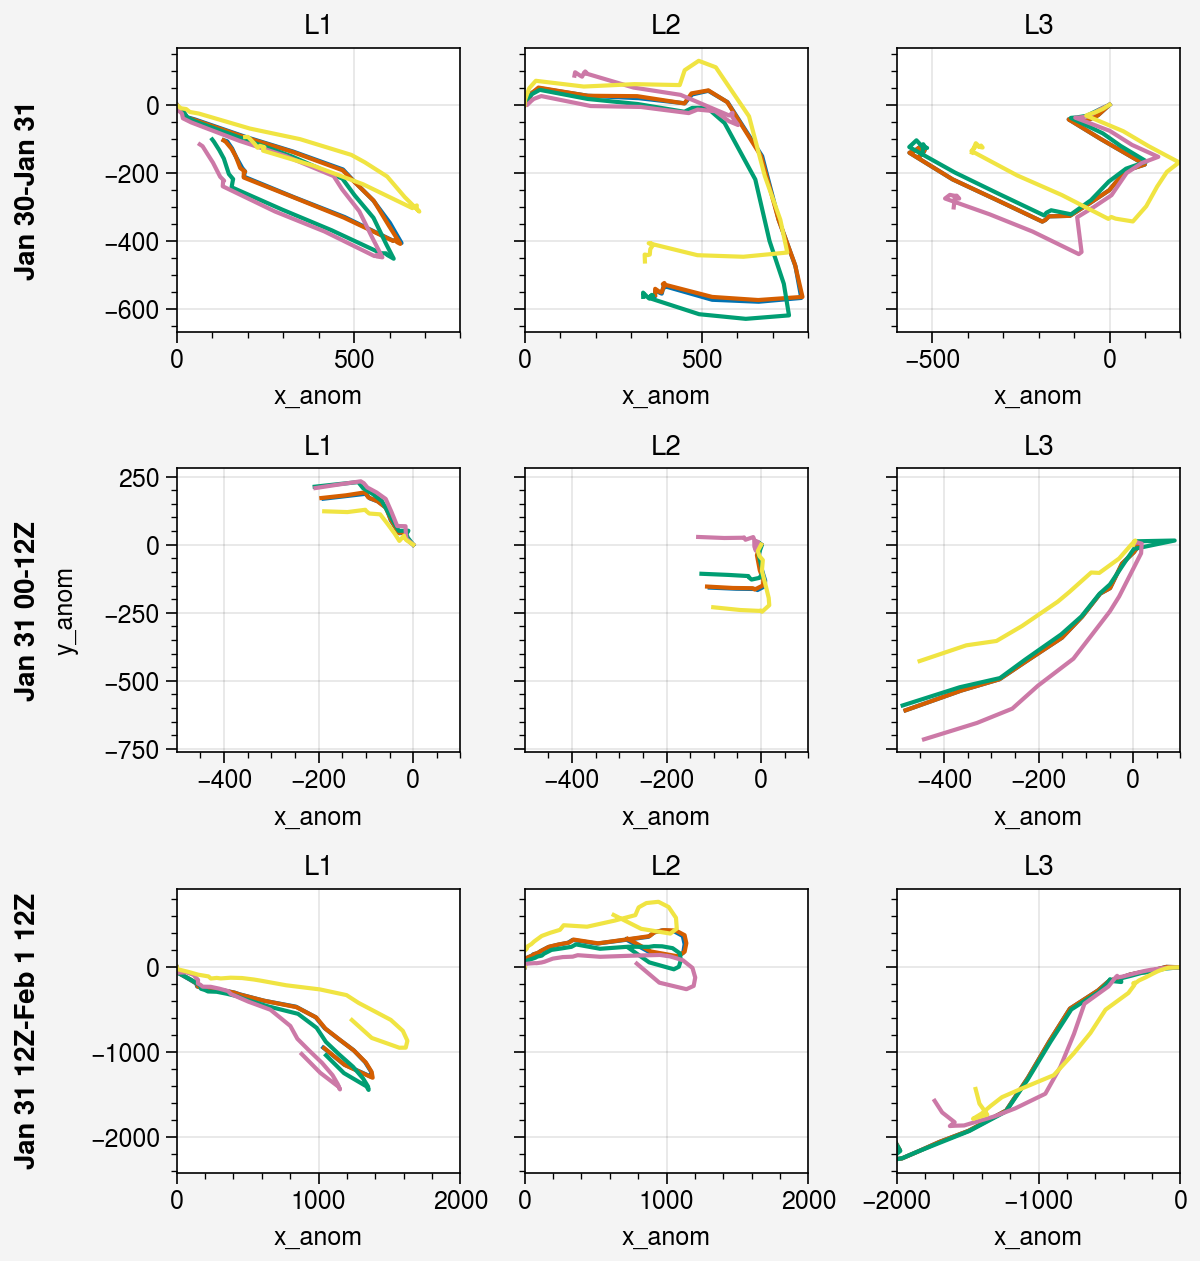

In [391]:
date = '2020-01-30 12:00'
events = {'Jan 30-Jan 31': slice('2020-01-30 00:00', '2020-01-31 00:00'),
          'Jan 31 00-12Z': slice('2020-01-31 00:00', '2020-01-31 12:00'),
          'Jan 31 12Z-Feb 1 12Z': slice('2020-01-31 12:00', '2020-02-01 12:00')}




fig, axs = pplt.subplots(nrows=3, ncols=3, width=6, sharex=False)
for event, row in zip(events, range(3)):
    timeslice=events[event]
    titles = ['L1', 'L2', 'L3']
    for node in polygons:
        for ax, buoy in zip(axs[row,:], polygons[node]):
            ax.plot(buoy_data[buoy]['x_anom'].loc[timeslice] - buoy_data[buoy]['x_anom'].loc[timeslice][0],
                buoy_data[buoy]['y_anom'].loc[timeslice] - buoy_data[buoy]['y_anom'].loc[timeslice][0])
        for col in range(3):
            axs[row, col].format(title=titles[col])
axs[0, 0].format(xlim=(0, 800))
axs[0, 1].format(xlim=(0, 800))
axs[0, 2].format(xlim=(-600,200))

axs[1, :].format(xlim=(-500,100))

axs[2, 0].format(xlim=(0, 2000))
axs[2, 1].format(xlim=(0, 2000))
axs[2, 2].format(xlim=(-2000, 0))
axs.format(leftlabels=[event for event in events], xreverse=False, yreverse=False)
fig.save('../figures/event_tracks_corners.jpg', dpi=300)

In [101]:
# Stretching time series
# Big dictionary that has distances for all dates in the range
dist = {}
X_data = pd.DataFrame({b: buoy_data[b].loc[timeslice]['x'] for b in buoy_data})
Y_data = pd.DataFrame({b: buoy_data[b].loc[timeslice]['y'] for b in buoy_data})
for date in X_data.index:
    dist[date] = pd.DataFrame(np.zeros((len(X_data.columns), len(X_data.columns))),
                        index=X_data.columns, columns=X_data.columns)
    for b1 in buoy_data:
        for b2 in buoy_data:
            dist[date].loc[b1, b2] = np.sqrt(
                (X_data.loc[date, b1] - X_data.loc[date, b2])**2 + \
            (Y_data.loc[date, b1] - Y_data.loc[date, b2])**2)

In [103]:
near_center = ['ASFSTUCB1', '2019P158', '2019T66', '2019P151', '2019T62', '2019S96',
       '2019P183', '2019P150']

In [104]:
def between_buoys_dist(b1, b2, dist_dict):
    """Extract time series from dist_dict"""
    dates = list(dist_dict.keys())
    distance = []
    for date in dates:
        distance.append(dist_dict[date].loc[b1, b2])
    d = pd.Series(distance, dates)
    return d.sort_index()

In [124]:
test = between_buoys_dist('ASFS50UCB1', 'ASFS40UCB1', dist)
test2 = between_buoys_dist('ASFS50UCB1', 'ASFS30UCB1', dist)
test3 = between_buoys_dist('ASFS30UCB1', 'ASFS40UCB1', dist)

<AxesSubplot:>

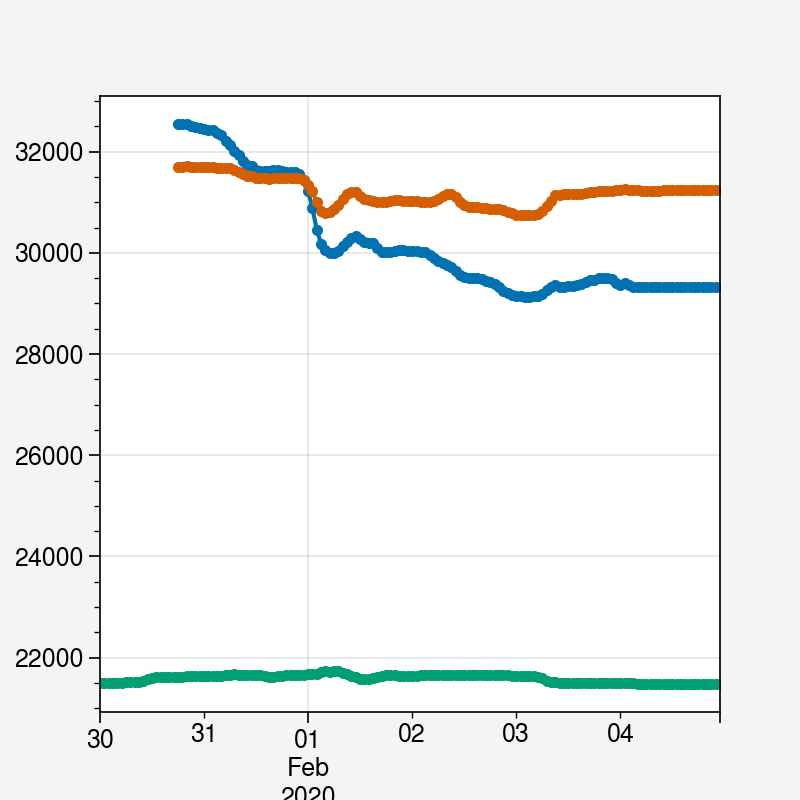

In [128]:
test.plot(marker='.')
test2.plot(marker='.')
test3.plot(marker='.')